In [39]:
from groq import Groq
import os
import pandas as pd
import numpy as np
import time

In [32]:
notes_df = pd.read_csv('note classification\\Notes.csv')
train_df = pd.read_csv('note classification\\train.csv')
test_df = pd.read_csv('note classification\\test.csv', encoding='cp1252')
test_df = test_df.dropna(subset=['label'])

In [ ]:
from groq import Groq

client = Groq(
    api_key='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'
)

predictions_df = pd.DataFrame(columns=['Index', 'Prediction', 'Response'])
    
mycount = 0
for segment_num in range(1,5):    
    for test_id in test_df['ID'].unique():
        mycount += 1
        test_rows = test_df[(test_df['ID'] == test_id) & (test_df['Segment'] == segment_num)]
        
        test_idx = test_rows.index[0]     
        print("Processing test row index:", test_idx)
        test_topic = test_rows['Topic'].values[0]
    
        mystr = ""
        idx = 1
        myid = None
        for _, row in train_df.iterrows():
            if row['Topic'] == test_topic and row['Segment'] == segment_num:
                mystr += f"Example {idx}:\n"
                mystr += f"Notes : {row['IdeaUnit']}\n"
                mystr += f"Covers the IdeaUnit? : {True if row['label'] else False}\n\n"
                myid = row['ID']
                idx+=1

        # print(mystr)  
        prompt = "You are an expert in analyzing student notes from a lecture to determine whether they cover a specific key point, called an “IdeaUnit”.\n\n"
        prompt += "Here is the example of an IdeaUnit and some examples of student notes and whether these notes cover the IdeaUnit or not:\n\n"
        
        train_row = notes_df[(notes_df['ID'] == myid)]
        train_ideaunit = train_row[f'Segment{test_row["Segment"]}_Notes'].values[0]

        prompt += f"IdeaUnit: {train_ideaunit}\n\n"
        prompt += "Below are notes from different students. For each note, check if it covers the IdeaUnit.\n\n"
        prompt += mystr
        
        prompt += "Using your understanding from the above examples, determine if the below IdeaUnit is covered by the series of notes which follows :\n\n" 
        
        check_row = notes_df[(notes_df['ID'] == test_id)]
        
        test_ideaunit = check_row[f'Segment{segment_num}_Notes'].values[0]
        
        prompt += f"IdeaUnit: {test_ideaunit}\n\n"
        
        idx = 1
        for _, row in test_rows.iterrows():
            prompt += f"Note {idx} : {row['IdeaUnit']}\n\n"
            idx+=1
        
        prompt += "For each note, check if it covers the IdeaUnit. Answer with 'True' or 'False'\n"
        prompt += "Response Format: (ONLY an Array of True/False where the index corresponds to the prediction for the note with that index)\n\n"
        
        error_count = 0
        while True:
            try:
                chat_completion = client.chat.completions.create(
                messages=[
                        {
                            "role": "user",
                            "content": prompt,
                        }
                    ],
                    model="meta-llama/llama-4-maverick-17b-128e-instruct",
                    stream=False,
                )
                
                response = chat_completion.choices[0].message.content   
            except Exception as e:
                print(f"Error occurred: {e}")
                error_count += 1
                if error_count > 50:
                    print("Error count exceeded, breaking out of loop.")
                    break
                time.sleep(2)  
                continue
            else:
                if not response:
                    print("Empty response, retrying...")
                    error_count += 1
                    if error_count > 50:
                        print("Error count exceeded, breaking out of loop.")
                        break
                    time.sleep(2)  
                    continue
                else:
                    break
        
        if error_count > 50:
            break
        
        og_response = response
        response = response.split('[')[1].split(']')[0]
        response = response.split(',')
        response = [x.strip() for x in response]
        response = [x.lower() == 'true' for x in response]
        
        for i in range(len(response)):
            predictions_df = predictions_df._append({'Index': test_rows.index[i], 'Prediction': response[i], 'Response': og_response}, ignore_index=True)
    
    predictions_df.to_csv('note classification\\left_predictions.csv', index=False)
    print(f"Predictions saved for Segment {segment_num}.")
    


Predictions saved for Segment 1.
Index([754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767,
       768],
      dtype='int64')
Processing test row index: 754
You are an expert in analyzing student notes from a lecture to determine whether they cover a specific key point, called an “IdeaUnit”.

Here is the example of an IdeaUnit and some examples of student notes and whether these notes cover the IdeaUnit or not:

IdeaUnit: BASICS OF COMPUTER SCIENCE Declarative Knowledge: Factual statements Imparative Knowledge: how-to statements, expressed in algorithms - steps in an exact order, such as how to perform a computation. Algorithm contains loops, telling the program to start over and repeat a process, termination code must be includedInfinite loop: missing termination code, program runs forever why are we talking about the germans i dont know what this has to do with anything Fixed Program: machine executes algorithms. Stored program computer. Operator prov

Below are not

In [ ]:
predictions_df.info()
predictions_df.to_csv('note classification\\predictions.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9945 entries, 0 to 9944
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Index       9945 non-null   object
 1   Prediction  9945 non-null   object
 2   Response    9945 non-null   object
dtypes: object(3)
memory usage: 233.2+ KB


In [136]:
test_df = pd.read_csv('note classification\\test.csv', encoding='cp1252')

Accuracy: 0.648667672197084
F1 Score: 0.6183923110528615
Precision: 0.5088980765773863
Recall: 0.7879209574172001


Text(0.5, 1.0, 'Confusion Matrix')

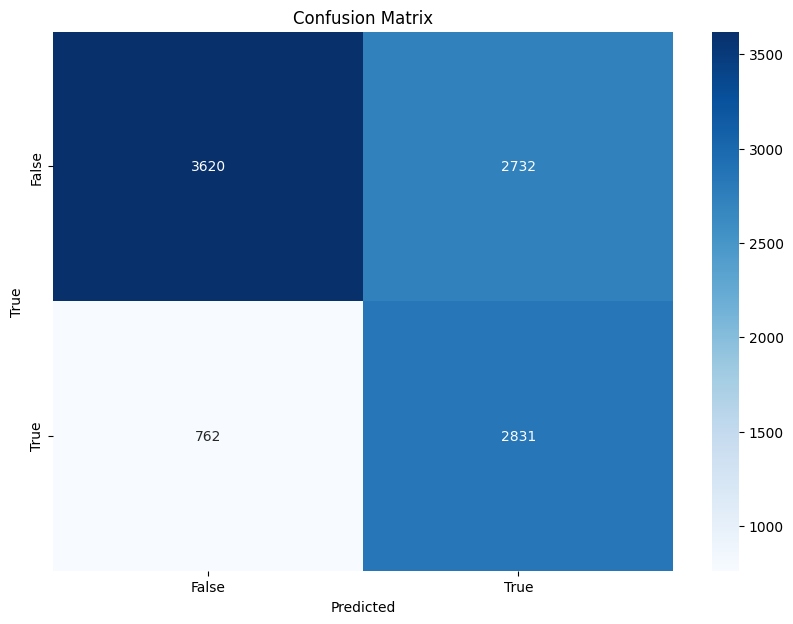

In [154]:
ground_truth = []
preds = []

for i in range(len(predictions_df)):
    ground_truth.append(test_df.iloc[predictions_df['Index'][i], -1])
    preds.append(1 if predictions_df['Prediction'][i] else 0)
    
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(ground_truth, preds)
f1 = f1_score(ground_truth, preds)
precision = precision_score(ground_truth, preds)
recall = recall_score(ground_truth, preds)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ground_truth, preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
